# **Importing Libraries**

In [ ]:
#Import libraries for Data Preprocessing & Data Augmentation
import os
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from skimage import io
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

#Import libraries for Model Implementation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from keras import layers, optimizers
from keras.layers import Input, Flatten
from keras.models import Sequential, Model
#from keras_tuner import RandomSearch
#from keras.tuner.engine.hyperparameters import HyperParameters
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
import warnings
warnings.simplefilter("ignore")

# **Loading and transforming dataset**

In [ ]:
def extract_feature(path, label):         #Load the images from given path and labeling
    data = []
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img), 0)
        if image is not None:
            data.append([image, label])
    return data

def transform_feature(data):              #Transform dataset using resize, rescale, reshape
    images, labels = [],[]
    size = 128
    for img,label in data:
        images.append((cv2.resize(img,(size,size)))/255)
        labels.append(label)
    img_array = np.array(images)
    X = img_array.reshape(img_array.shape[0],img_array.shape[1],img_array.shape[2],1)
    return X, labels

def vgg_transform_feature(data):         #Transform dataset using resize, rescale, reshape for Xception model
    images, labels = [],[]
    size = 299
    for img,label in data:
        images.append((cv2.resize(img,(size,size)))/255)
        labels.append(label)
    img_array = np.array(images)
    X = img_array.reshape(img_array.shape[0],img_array.shape[1],img_array.shape[2],1)
    return X, labels

In [ ]:
data = extract_feature("/content/drive/MyDrive/BREAST_CANCER/DETECT/benign",0) #Call the function to load images with label
data.extend(extract_feature("/content/drive/MyDrive/BREAST_CANCER/DETECT/malignant",1))

In [ ]:
X, labels = transform_feature(data)   #Call the function to transform and return with image array & label
X.shape

(1312, 128, 128, 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X , labels, train_size=0.75, random_state=42)

# **Augmented Data**

**Generator for augmenting data**

In [ ]:
data_generator = ImageDataGenerator(       #Parameters for data augmentation
    rotation_range = 20,
    shear_range = 0.2,
    horizontal_flip = True
)

cnt_path = r'/content/drive/MyDrive/BREAST_CANCER/DETECT/benign/'
size = 224
img_list = []
images = os.listdir(cnt_path)
for _, img_name in enumerate(images):
    if (img_name.split('.')[1] == 'png'):
        img = io.imread(cnt_path + img_name)
        img = Image.fromarray(img, 'RGB')
        img = img.resize((size,size))
        img_list.append(np.array(img))
img_array = np.array(img_list)
i = 0
for _ in data_generator.flow(img_array, batch_size=8, save_to_dir= r'aug_data/benign',
                             save_prefix='aug', save_format='png'):
    i += 1
    if i > 200:
        break

ValueError: ignored

In [ ]:
def aug_transform_feature(data):              #Transform dataset using resize, rescale, reshape
    images, labels = [],[]
    size=128
    for img,label in data:
        images.append((cv2.resize(img,(size,size)))/255)
        labels.append(label)
    img_array = np.array(images)
    X = img_array.reshape(img_array.shape[0],img_array.shape[1],img_array.shape[2],1)
    return X, labels

In [ ]:
aug_data = extract_feature("aug_data/benign",0)
aug_data.extend(extract_feature("aug_data/malignant",1))

FileNotFoundError: ignored

In [ ]:
x, label = aug_transform_feature(aug_data)
x.shape

NameError: ignored

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x , label, train_size=0.75, random_state=42)

NameError: ignored

**Function for classification report of any model**

In [ ]:
def report(model, aug = False):
    if aug:
        xtest = x_test
        y_true = y_test
    else:
        xtest = X_test
        y_true = Y_test
    y_pred = []
    for i in model.predict(xtest,batch_size=10,verbose=0):
        y_pred.append(np.argmax(i))
    print(classification_report(y_true, y_pred, target_names= ['benign','malignant']))

# **BASE MODEL**

In [ ]:
#First Base Model
model1 = Sequential([
    layers.Conv2D(16, 4, padding = 'same', activation = 'relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation = 'softmax')
])

#Compile the model with optimizer and metrics
model1.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

#Review the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
#Train the model
result = model1.fit(np.array(X_train), np.array(Y_train), epochs = 25,
                    validation_data=(X_test, np.array(Y_test)), verbose = 2)

Epoch 1/25
31/31 - 31s - loss: 0.6822 - accuracy: 0.6382 - val_loss: 0.6750 - val_accuracy: 0.6921 - 31s/epoch - 1s/step
Epoch 2/25
31/31 - 28s - loss: 0.5994 - accuracy: 0.6758 - val_loss: 0.6715 - val_accuracy: 0.6921 - 28s/epoch - 915ms/step
Epoch 3/25
31/31 - 27s - loss: 0.5429 - accuracy: 0.7185 - val_loss: 0.6786 - val_accuracy: 0.7073 - 27s/epoch - 887ms/step
Epoch 4/25
31/31 - 27s - loss: 0.4851 - accuracy: 0.7693 - val_loss: 0.7406 - val_accuracy: 0.3079 - 27s/epoch - 864ms/step
Epoch 5/25
31/31 - 26s - loss: 0.4051 - accuracy: 0.8089 - val_loss: 0.6893 - val_accuracy: 0.5305 - 26s/epoch - 854ms/step
Epoch 6/25
31/31 - 28s - loss: 0.2880 - accuracy: 0.8913 - val_loss: 0.6816 - val_accuracy: 0.5183 - 28s/epoch - 917ms/step
Epoch 7/25
31/31 - 27s - loss: 0.2280 - accuracy: 0.9065 - val_loss: 0.7156 - val_accuracy: 0.4695 - 27s/epoch - 884ms/step
Epoch 8/25
31/31 - 29s - loss: 0.2209 - accuracy: 0.9126 - val_loss: 0.6170 - val_accuracy: 0.5884 - 29s/epoch - 927ms/step
Epoch 9/25


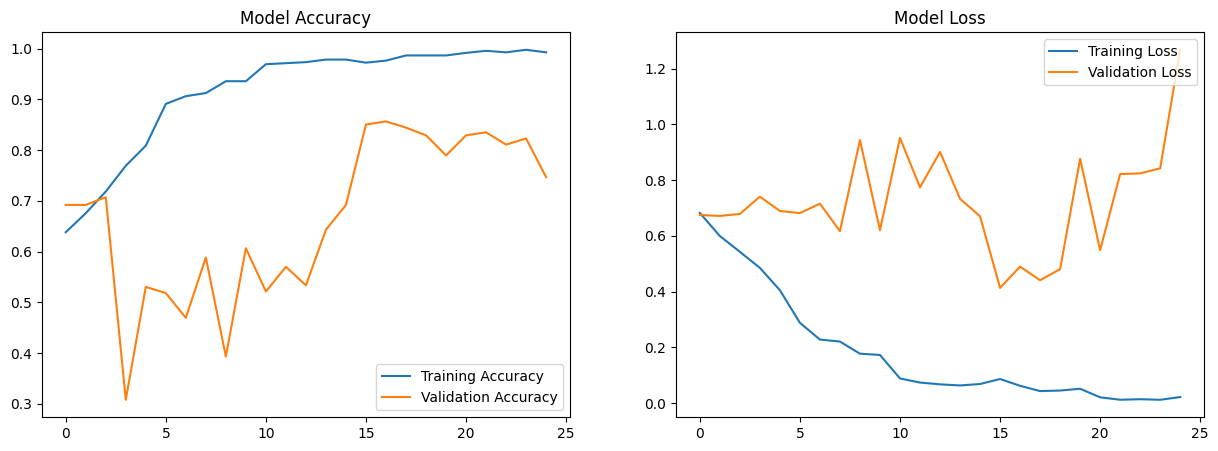

In [ ]:
#Model performance
accuracy = result.history['accuracy']
val_accuracy = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

epochs = range(25)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [ ]:
report(model1)

              precision    recall  f1-score   support

      benign       0.86      0.75      0.80       227
   malignant       0.57      0.73      0.64       101

    accuracy                           0.75       328
   macro avg       0.72      0.74      0.72       328
weighted avg       0.77      0.75      0.75       328



# **BASE Model with Augmentation**

In [ ]:
#First base model
model2 = Sequential([
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation = 'softmax')
])

#Compile the model with optimizer and metrics
model2.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

#Review the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)      

In [ ]:
#Train the model
result = model2.fit(np.array(x_train), np.array(y_train), epochs = 50,
                    validation_data=(x_test, np.array(y_test)), verbose = 2)

Epoch 1/50
31/31 - 21s - loss: 0.7485 - accuracy: 0.6220 - val_loss: 0.6740 - val_accuracy: 0.6921 - 21s/epoch - 688ms/step
Epoch 2/50
31/31 - 19s - loss: 0.6273 - accuracy: 0.6748 - val_loss: 0.6595 - val_accuracy: 0.6921 - 19s/epoch - 628ms/step
Epoch 3/50
31/31 - 18s - loss: 0.5805 - accuracy: 0.7002 - val_loss: 0.6369 - val_accuracy: 0.6921 - 18s/epoch - 583ms/step
Epoch 4/50
31/31 - 18s - loss: 0.5356 - accuracy: 0.7348 - val_loss: 0.6269 - val_accuracy: 0.6921 - 18s/epoch - 589ms/step
Epoch 5/50
31/31 - 19s - loss: 0.4965 - accuracy: 0.7561 - val_loss: 0.6267 - val_accuracy: 0.6982 - 19s/epoch - 625ms/step
Epoch 6/50
31/31 - 19s - loss: 0.4339 - accuracy: 0.8008 - val_loss: 0.6008 - val_accuracy: 0.7470 - 19s/epoch - 614ms/step
Epoch 7/50
31/31 - 19s - loss: 0.3779 - accuracy: 0.8262 - val_loss: 0.5773 - val_accuracy: 0.7012 - 19s/epoch - 615ms/step
Epoch 8/50
31/31 - 18s - loss: 0.3063 - accuracy: 0.8608 - val_loss: 0.5316 - val_accuracy: 0.7622 - 18s/epoch - 576ms/step
Epoch 9/

ValueError: ignored

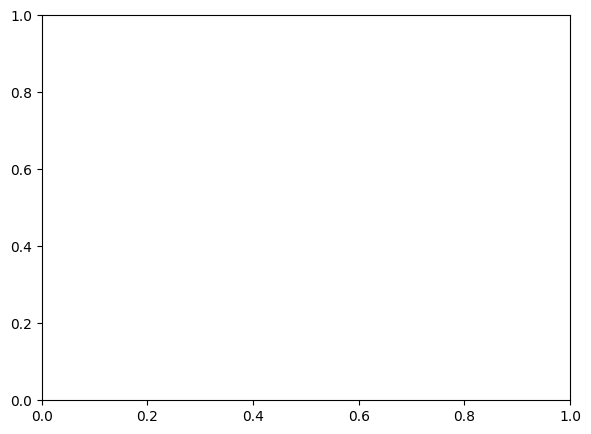

In [ ]:
#Model performance
accuracy = result.history['accuracy']
val_accuracy = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

epochs = range(50)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [ ]:
report(model2, True)

# **BASE Model with Keras Tuner**

In [ ]:
def tuned_model(hp):  #Function for tuning model
  model = keras.Sequential([
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [4,5]),
        activation='relu',
        input_shape=(128,128,1)
    ),
    layers.MaxPooling2D(),
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [4,5]),
        activation='relu',
        input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units = hp.Int('dense_1_units', min_value=32, max_value=128, step=32), activation='relu'),
    layers.Dense(2, activation='softmax')
  ])

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
random_search = RandomSearch(tuned_model, objective='val_accuracy',
                          max_trials = 3, directory = 'output', project_name = "bcc")

NameError: ignored

In [ ]:
#Search best parameters by training model
random_search.search(np.array(X_train), np.array(Y_train), epochs = 5, validation_data=(X_test, np.array(Y_test)))

NameError: ignored

In [ ]:
model3 = random_search.get_best_models(num_models=1)[0]  #Find the best parameter model
model3.summary()

NameError: ignored

In [ ]:
result = model3.fit(np.array(X_train), np.array(Y_train), epochs = 25,
            validation_data=(X_test, np.array(Y_test)), initial_epoch=5)

NameError: ignored

In [ ]:
report(model3)

# **BASE Model with Keras Tuner & Augmentation**

In [ ]:
random_search = RandomSearch(tuned_model, objective='val_accuracy',
                          max_trials = 3, directory = 'output', project_name = "augbcc")

NameError: ignored

In [ ]:
#Search best parameters by training model
random_search.search(np.array(x_train), np.array(y_train), epochs = 5, validation_data=(x_test, np.array(y_test)))

NameError: ignored

In [ ]:
model4 = random_search.get_best_models(num_models=1)[0]   #Find the best parameter model
model4.summary()

In [ ]:
result= model4.fit(np.array(x_train), np.array(y_train), epochs = 25,
            validation_data=(x_test, np.array(y_test)), initial_epoch=5)

Epoch 6/15
31/31 [==============================] - 87s 3s/step - loss: 0.1725 - accuracy: 0.9299 - val_loss: 0.7649 - val_accuracy: 0.8018
Epoch 7/15
31/31 [==============================] - 84s 3s/step - loss: 0.1246 - accuracy: 0.9553 - val_loss: 1.1713 - val_accuracy: 0.7622
Epoch 8/15
31/31 [==============================] - 83s 3s/step - loss: 0.0893 - accuracy: 0.9654 - val_loss: 0.9173 - val_accuracy: 0.8293
Epoch 9/15
31/31 [==============================] - 80s 3s/step - loss: 0.0742 - accuracy: 0.9776 - val_loss: 1.0758 - val_accuracy: 0.7713
Epoch 10/15
31/31 [==============================] - 83s 3s/step - loss: 0.0638 - accuracy: 0.9817 - val_loss: 1.2674 - val_accuracy: 0.7957
Epoch 11/15
31/31 [==============================] - 83s 3s/step - loss: 0.0334 - accuracy: 0.9868 - val_loss: 1.3122 - val_accuracy: 0.7957
Epoch 12/15
31/31 [==============================] - 84s 3s/step - loss: 0.0233 - accuracy: 0.9939 - val_loss: 1.4231 - val_accuracy: 0.7896
Epoch 13/15
31/31

In [ ]:
report(model4, True)

# **AlexNet**

In [ ]:
model5 = Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,1)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 96)        11712     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
model5.fit(np.array(X_train), np.array(Y_train), epochs = 25, validation_data=(X_test, np.array(Y_test)), verbose = 2,
          validation_freq=1)

Epoch 1/25
31/31 - 66s - loss: 3.7367 - accuracy: 0.5955 - val_loss: 0.8850 - val_accuracy: 0.6890 - 66s/epoch - 2s/step
Epoch 2/25
31/31 - 61s - loss: 0.9300 - accuracy: 0.6514 - val_loss: 0.7174 - val_accuracy: 0.6555 - 61s/epoch - 2s/step
Epoch 3/25
31/31 - 62s - loss: 0.6677 - accuracy: 0.6789 - val_loss: 0.7044 - val_accuracy: 0.5854 - 62s/epoch - 2s/step
Epoch 4/25
31/31 - 63s - loss: 0.5899 - accuracy: 0.7195 - val_loss: 0.9815 - val_accuracy: 0.6921 - 63s/epoch - 2s/step
Epoch 5/25
31/31 - 61s - loss: 0.5196 - accuracy: 0.7612 - val_loss: 1.0431 - val_accuracy: 0.5396 - 61s/epoch - 2s/step
Epoch 6/25
31/31 - 61s - loss: 0.5260 - accuracy: 0.7520 - val_loss: 1.0556 - val_accuracy: 0.5335 - 61s/epoch - 2s/step
Epoch 7/25
31/31 - 67s - loss: 0.4633 - accuracy: 0.7866 - val_loss: 1.0691 - val_accuracy: 0.6555 - 67s/epoch - 2s/step
Epoch 8/25
31/31 - 62s - loss: 0.4314 - accuracy: 0.8049 - val_loss: 1.2610 - val_accuracy: 0.6829 - 62s/epoch - 2s/step
Epoch 9/25
31/31 - 62s - loss: 0

In [ ]:
report(model5)

              precision    recall  f1-score   support

      benign       0.77      0.80      0.78       227
   malignant       0.51      0.46      0.48       101

    accuracy                           0.70       328
   macro avg       0.64      0.63      0.63       328
weighted avg       0.69      0.70      0.69       328



# **ResNet50**

In [ ]:
restnet = ResNet50(include_top = False, weights= None , input_shape=(128, 128, 1))
output = restnet.layers[-1].output
output = layers.Flatten()(output)

restnet = Model(restnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

model6 = Sequential([
            restnet,
            layers.Dense(2, activation="softmax")
])

model6.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
optimizer='adam',
metrics=['accuracy'])
model6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 32768)             23581440  
                                                                 
 dense_11 (Dense)            (None, 2)                 65538     
                                                                 
Total params: 23,646,978
Trainable params: 65,538
Non-trainable params: 23,581,440
_________________________________________________________________


In [ ]:
result = model6.fit(
    np.array(X_train),
    np.array(Y_train),
    steps_per_epoch=len(X_train),
    epochs=10,
    validation_data=(X_test, np.array(Y_test)),
    validation_steps=len(X_test),
    verbose=2
)

In [ ]:
report(model6)

# **DenseNet 201**

In [ ]:
densenet = DenseNet201(include_top = False, weights = None , input_shape = (128, 128, 1))
output = densenet.layers[-1].output
output = keras.layers.Flatten()(output)

densenet = Model(densenet.input, output)

for layer in densenet.layers:
    layer.trainable = False

model7 = Sequential([
            densenet,
            layers.Dense(2, activation="softmax")
])

model7.compile( loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
optimizer='adam',
metrics=[ 'accuracy'])
model7.summary()

In [ ]:
result = model7.fit(
    np.array(X_train),
    np.array(Y_train),
    steps_per_epoch=len(X_train),
    epochs=10,
    validation_data=(X_test, np.array(Y_test)),
    validation_steps=len(Y_test),
    verbose=2
)

In [ ]:
report(model7)

# **VGG16**

In [ ]:
X, labels = vgg_transform_feature(data)   #Call the function to transform and return with image array & label
X_train, X_test, Y_train, Y_test = train_test_split(X , labels, train_size=0.75, random_state=42)

In [ ]:
vgg = VGG16(input_shape = (299, 299, 1), weights=None, include_top=False)

for layer in vgg.layers:       #To freeze the previous layers
  layer.trainable = False

x = Flatten()(vgg.output)
output = layers.Dense(2, activation='softmax')(x)

model8 = Model(inputs=vgg.input, outputs=output)
model8.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
  optimizer='adam',
  metrics=['accuracy']
)
model8.summary()

In [ ]:
result = model8.fit(
    np.array(X_train),
    np.array(Y_train),
    steps_per_epoch=len(X_train),
    epochs=10,
    validation_data=(X_test, np.array(Y_test)),
    validation_steps=len(Y_test),
    verbose=2
)

Epoch 1/10
984/984 - 1443s - loss: 0.6239 - accuracy: 0.6789 - val_loss: 0.6002 - val_accuracy: 0.6951 - 1443s/epoch - 1s/step
Epoch 2/10
984/984 - 1413s - loss: 0.6118 - accuracy: 0.6890 - val_loss: 0.5966 - val_accuracy: 0.7256 - 1413s/epoch - 1s/step
Epoch 3/10


In [ ]:
report(model8)